In [1]:
import xarray as xr
import numpy as np
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
import xrft

In [2]:
# Load velocities
vels_filtered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/filtered_vels.zarr')
vels_unfiltered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/unfiltered_vels.zarr')
eta_filtered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/filtered_eta_nom.zarr')
eta_unfiltered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/unfiltered_eta_nom.zarr')

uvel_eul = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel_centered.zarr').sel(k=0)
vvel_eul = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel_centered.zarr').sel(k=0)
eta_eul = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta.zarr')

uvel_eul = uvel_eul.isel(time=slice(1,2000))
vvel_eul = vvel_eul.isel(time=slice(1,2000))
eta_eul = eta_eul.isel(time=slice(1,2000))

u_filtered = vels_filtered.u.isel(time=slice(2,110))
v_filtered = vels_filtered.v.isel(time=slice(2,110))
ssh_filtered = eta_filtered.eta.isel(time=slice(2,110))

u_unfiltered = vels_unfiltered.u.isel(time=slice(2,110))
v_unfiltered = vels_unfiltered.v.isel(time=slice(2,110))
ssh_unfiltered = eta_unfiltered.eta.isel(time=slice(2,110))

ds = xr.open_zarr('/swot/SUM01/spencer/36hr_timeseries/rechunked_6048.zarr')
ds = ds.isel(niter=slice(1,74))
ds['time'] = ds['niter']*3600/144
ds = ds.assign_coords({"time": ds.time})
ds = ds.swap_dims({"niter": "time"})
ds = ds.where(ds.u!=-999)

grid = Grid(u_filtered, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

In [4]:
def lanczos(x, a):
    return np.sinc(x/a)
def sinc2(x, a):
    return np.sinc(x/a)

YC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YC.data', dtype='>f4')
f = 2*2*np.pi/24/3600*np.sin(YC.reshape(2160,2160)[:,0]*np.pi/180)
window_width=72
weight = xr.DataArray(sinc2(np.expand_dims(np.arange(-window_width/2,window_width/2),1),np.expand_dims(np.pi/f/3600*1.1,0)), dims=['window','j'])
#weight = xr.DataArray(sinc2(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
nofiles=u_unfiltered.time.shape[0]
u_eul_filtered = uvel_eul.U.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
v_eul_filtered = vvel_eul.V.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
eta_eul_filtered = eta_eul.Eta.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
u_eul_filtered = u_eul_filtered.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
v_eul_filtered = v_eul_filtered.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
eta_eul_filtered = eta_eul_filtered.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
uvel_eul = uvel_eul.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
vvel_eul = vvel_eul.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
eta_eul = eta_eul.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})

In [82]:
def lanczos(x, a):
    return np.sinc(x/a)

window_width=72
weight = xr.DataArray(sinc2(np.expand_dims(np.arange(-window_width/2,window_width/2),1),np.expand_dims(np.pi/f/3600*1.1,0)), dims=['window','j'])

windowed_u = ds.u.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)

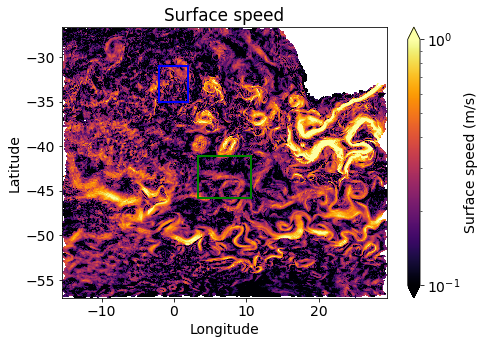

In [68]:
plt.figure(figsize=(7,5))
from matplotlib.colors import LogNorm
(np.sqrt(u_unfiltered**2+v_unfiltered**2)).where(np.sqrt(u_filtered**2+v_filtered**2)>0).isel(time=0).rename('Surface speed (m/s)').plot.pcolormesh(
        x='x0',y='y0',norm=LogNorm(),vmin=10**-1,vmax=1,rasterized=True,cbar_kwargs={'extend':'both'}, cmap='inferno')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('')

ax=plt.gca()
rect = patches.Rectangle((-2, -35), 4, 4, linewidth=2, edgecolor='b', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

rect = patches.Rectangle((3.34, -45.82), 7.26, 4.69, linewidth=2, edgecolor='g', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
plt.title('Surface speed')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("unfiltered.png")

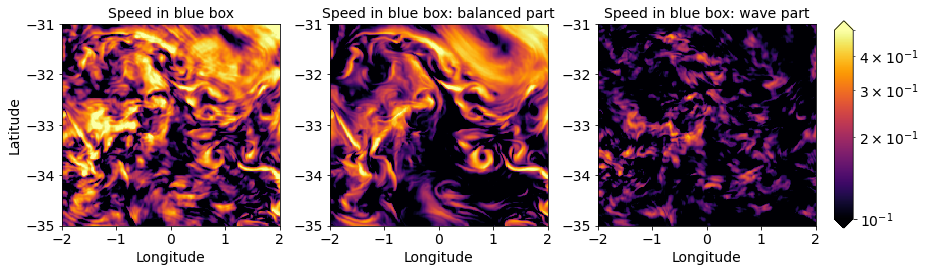

In [5]:
plt.figure(figsize=(13,4))
from matplotlib.colors import LogNorm
plt.subplot(131)
(np.sqrt(u_unfiltered**2+v_unfiltered**2)).where(np.sqrt(u_filtered**2+v_filtered**2)>0).isel(time=0).rename('Surface speed (m/s)').plot.pcolormesh(
        x='x0',y='y0',norm=LogNorm(),vmin=10**-1,vmax=0.5,rasterized=True,add_colorbar=False, cmap='inferno')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Speed in blue box',fontsize=14)
plt.xlim(-2,2)
plt.ylim(-35,-31)

plt.subplot(132)
(np.sqrt(u_filtered**2+v_filtered**2)).where(np.sqrt(u_filtered**2+v_filtered**2)>0).isel(time=0).rename('Surface speed (m/s)').plot.pcolormesh(
        x='x0',y='y0',norm=LogNorm(),vmin=10**-1,vmax=0.5,rasterized=True,add_colorbar=False, cmap='inferno')
plt.xlabel('Longitude')
plt.ylabel('')
plt.title('Speed in blue box: balanced part',fontsize=14)
plt.xlim(-2,2)
plt.ylim(-35,-31)

plt.subplot(133)
cs = (np.sqrt((u_unfiltered-u_filtered)**2+(v_unfiltered-v_filtered)**2)).where(np.sqrt(u_filtered**2+v_filtered**2)>0).isel(time=0).rename('Surface speed (m/s)').plot.pcolormesh(
        x='x0',y='y0',norm=LogNorm(),vmin=10**-1,vmax=0.5,rasterized=True,add_colorbar=False, cmap='inferno')
plt.xlabel('Longitude')
plt.ylabel('')
plt.title('Speed in blue box: wave part',fontsize=14)
plt.xlim(-2,2)
plt.ylim(-35,-31)

fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax,extend='both')
fig = plt.gcf()
fig.savefig("unfiltered_zoom.png")

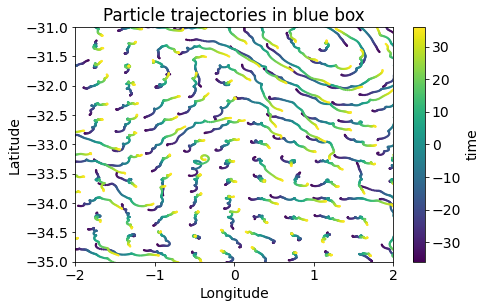

In [99]:
plt.figure(figsize=(7,4.5))
#ds.isel(z0=3,y0=slice(500,2000),x0=slice(0,1000)).plot.scatter(x='x0', y='y0',hue='z0',cmap='binary', s=0.1,vmax=-0.4,vmin=-10,add_guide=False)
ds.isel(x0=np.arange(0,2160,20),y0=np.arange(0,2160,20),z0=3).assign_coords(time=ds.time/3600).plot.scatter(x='x', y='y', hue='time',cmap='viridis', s=1.6)
plt.xlim(-2,2)
plt.ylim(-35,-31)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Particle trajectories in blue box')

#ax=plt.gca()
#rect = patches.Rectangle((-0.3, -33.1), 0.5, 0.4, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
#ax.add_patch(rect)

plt.tight_layout()
fig = plt.gcf()
fig.savefig("particle_traj.png")

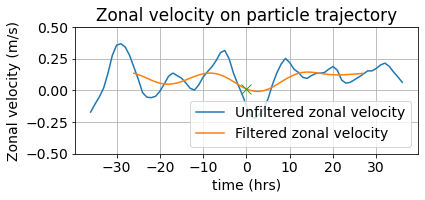

In [7]:
plt.figure(figsize=(6,3))
ds.isel(x0=740,y0=1780,z0=3).assign_coords(time=ds.time/3600).u.plot(label='Unfiltered zonal velocity')
windowed_u.isel(x0=740,y0=1780,z0=3).assign_coords(time=ds.time/3600).plot(label='Filtered zonal velocity')
plt.plot(0,windowed_u.isel(x0=740,y0=1780,z0=3).sel(time=0).values,marker='x',markersize=10)
plt.grid()
plt.title('Zonal velocity on particle trajectory')
plt.xlabel('time (hrs)')
plt.ylabel('Zonal velocity (m/s)')
plt.legend()
plt.ylim(-0.5,0.5)
plt.tight_layout()

fig = plt.gcf()
fig.savefig("smoothed_vel.png")

In [10]:
eta_eul

<xarray.Dataset>
Dimensions:  (i: 2160, j: 2160, time: 420)
Coordinates:
    face     int64 ...
  * i        (i) int64 1080 1081 1082 1083 1084 ... 3235 3236 3237 3238 3239
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * j        (j) float64 0.0 1.0 2.0 3.0 ... 2.157e+03 2.158e+03 2.159e+03
  * time     (time) timedelta64[ns] NaT 3 days 00:00:00 ... 20 days 10:00:00
    x        (j, i) float32 dask.array<chunksize=(270, 540), meta=np.ndarray>
    y        (j, i) float32 dask.array<chunksize=(270, 540), meta=np.ndarray>
Data variables:
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 270, 540), meta=np.ndarray>

In [5]:
with ProgressBar():
    u2_ps_eul = xrft.power_spectrum(uvel_eul.U.drop_vars('time').chunk({'time':-1}), dim=['time'],window=True,window_correction=True).compute()
    v2_ps_eul = xrft.power_spectrum(vvel_eul.V.drop_vars('time').chunk({'time':-1}), dim=['time'],window=True,window_correction=True).compute()
    eta_ps_eul = xrft.power_spectrum(eta_eul.Eta.drop_vars('time').chunk({'time':-1}), dim=['time'],window=True,window_correction=True).compute()
vel_ps_eul = (u2_ps_eul + v2_ps_eul)*0.5

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed | 28.9s


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed | 26.4s


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed | 34.5s


In [7]:
with ProgressBar():
    u2_ps_eulf = xrft.power_spectrum(u_eul_filtered.drop_vars('time').chunk({'time':-1}), dim=['time'],window=True,window_correction=True).compute()
    v2_ps_eulf = xrft.power_spectrum(v_eul_filtered.drop_vars('time').chunk({'time':-1}), dim=['time'],window=True,window_correction=True).compute()
    eta_ps_eulf = xrft.power_spectrum(eta_eul_filtered.drop_vars('time').chunk({'time':-1}), dim=['time'],window=True,window_correction=True).compute()
vel_ps_eulf = (u2_ps_eulf + v2_ps_eulf)*0.5

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  4min 55.8s


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  5min  5.7s


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  5min 13.9s


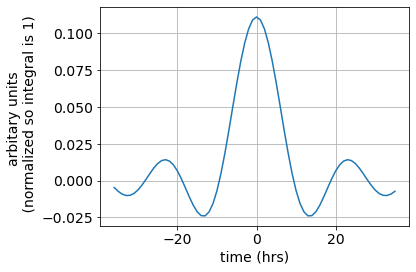

In [79]:
(weight.assign_coords(window=np.arange(-36,36)).isel(j=1000)/(weight.assign_coords(window=np.arange(-36,36)).isel(j=1000)).sum('window')).plot()
plt.grid()
plt.xlabel('time (hrs)')
plt.ylabel('arbitary units \n (normalized so integral is 1)')
plt.tight_layout()

fig = plt.gcf()
fig.savefig("sinc_window.png")

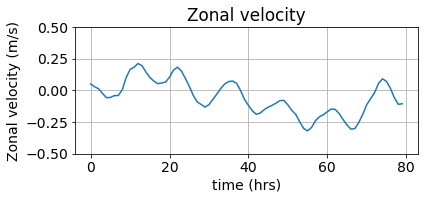

In [98]:
plt.figure(figsize=(6,3))
uvel_eul.U.isel(i=740,j=1000).assign_coords(time=uvel_eul.time/3600).plot(label='Unfiltered zonal velocity')
#windowed_u.isel(x0=740,y0=1780,z0=3).assign_coords(time=ds.time/3600).plot(label='Filtered zonal velocity')
#plt.plot(0,windowed_u.isel(x0=740,y0=1780,z0=3).sel(time=0).values,marker='x',markersize=10)
plt.grid()
plt.title('Zonal velocity')
plt.xlabel('time (hrs)')
plt.ylabel('Zonal velocity (m/s)')
#plt.legend()
plt.ylim(-0.5,0.5)
plt.tight_layout()

fig = plt.gcf()
fig.savefig("u_vel.png")

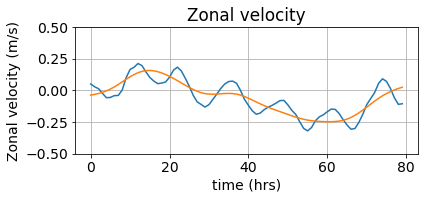

In [97]:
plt.figure(figsize=(6,3))
uvel_eul.U.isel(i=740,j=1000).assign_coords(time=uvel_eul.time/3600).plot(label='Unfiltered zonal velocity')
u_eul_filtered.isel(i=740,j=1000).assign_coords(time=uvel_eul.time/3600).plot(label='Filtered zonal velocity')
#windowed_u.isel(x0=740,y0=1780,z0=3).assign_coords(time=ds.time/3600).plot(label='Filtered zonal velocity')
#plt.plot(0,windowed_u.isel(x0=740,y0=1780,z0=3).sel(time=0).values,marker='x',markersize=10)
plt.grid()
plt.title('Zonal velocity')
plt.xlabel('time (hrs)')
plt.ylabel('Zonal velocity (m/s)')
#plt.legend()
plt.ylim(-0.5,0.5)
plt.tight_layout()

fig = plt.gcf()
fig.savefig("u_conv.png")

In [96]:
u_eul_filtered

<xarray.DataArray (time: 80, j: 2160, i: 2160)>
dask.array<getitem, shape=(80, 2160, 2160), dtype=float64, chunksize=(80, 270, 270), chunktype=numpy.ndarray>
Coordinates:
  * j        (j) float64 0.0 1.0 2.0 3.0 ... 2.157e+03 2.158e+03 2.159e+03
    k        int64 0
  * time     (time) int64 0 3600 7200 10800 ... 273600 277200 280800 284400
    x        (j, i) float32 dask.array<chunksize=(270, 270), meta=np.ndarray>
    y        (j, i) float32 dask.array<chunksize=(270, 270), meta=np.ndarray>
Dimensions without coordinates: i

KeyboardInterrupt: 

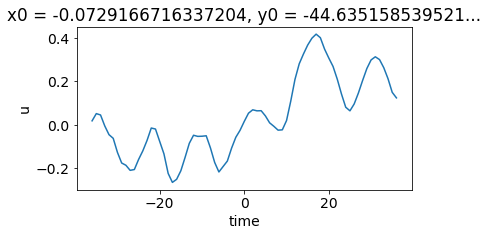

In [86]:
windowed_u = ds.u.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
plt.figure(figsize=(6,3))
ds.isel(x0=740,y0=1000,z0=3).assign_coords(time=ds.time/3600).u.plot(label='Unfiltered zonal velocity')
windowed_u.assign_coords(time=ds.time/3600).plot(label='Filtered zonal velocity')
#plt.plot(0,windowed_u.isel(x0=740,y0=1000,z0=3).sel(time=0).values,marker='x',markersize=10)
plt.grid()
plt.title('Zonal velocity')
plt.xlabel('time (hrs)')
plt.ylabel('Zonal velocity (m/s)')
plt.legend()
plt.ylim(-0.5,0.5)
plt.tight_layout()

fig = plt.gcf()
fig.savefig("u_conv.png")

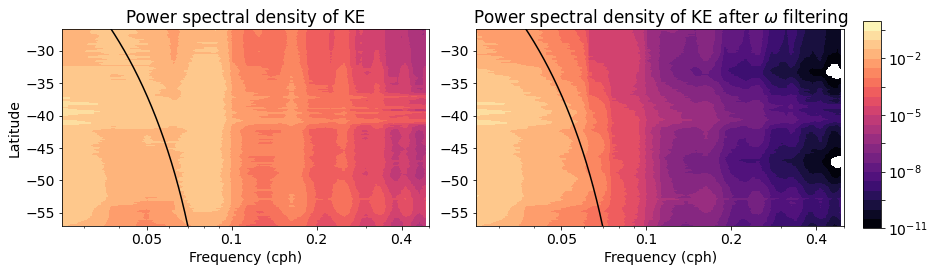

In [100]:
lev_exp = np.linspace(-11,0,23)
lev = np.power(10, lev_exp)
xticks_s = [5*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(13,4))
plt.subplot(121)
cs = plt.contourf(vel_ps_eul.freq_time[40:], vel_ps_eul.y[:,0], vel_ps_eul.mean('i')[40:,:].T,levels=lev,norm=LogNorm(),cmap='magma')
#plt.colorbar(cs)
plt.xscale('log')
plt.xlim(0.025,0.5)
plt.plot(-3600*f/np.pi/2,vel_ps_eul.y[:,0],color='k')
plt.xticks(xticks_s,xticks_s)
plt.ylabel('Latitude')
plt.xlabel ('Frequency (cph)')
plt.title('Power spectral density of KE')

plt.subplot(122)
cs = plt.contourf(vel_ps_eul.freq_time[40:], vel_ps_eul.y[:,0], vel_ps_eulf.mean('i')[40:,:].T,levels=lev,norm=LogNorm(),cmap='magma')
#plt.colorbar(cs)
plt.xscale('log')
plt.xlim(0.025,0.5)
plt.plot(-3600*f/np.pi/2,vel_ps_eul.y[:,0],color='k')
plt.xticks(xticks_s,xticks_s)
plt.xlabel ('Frequency (cph)')
plt.title('Power spectral density of KE after $\omega$ filtering')

fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)

fig.savefig("eulerian_latitude.png")

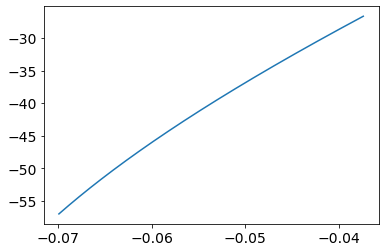

In [59]:
plt.plot(3600*f/np.pi/2,vel_ps_eul.y[:,0])

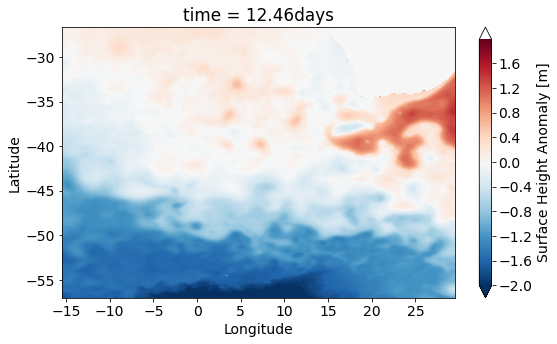

In [6]:
plt.figure(figsize=(8,5))
for tt in range(0,300):
    plt.clf()
    eta_merged.Eta.isel(time=tt).plot.pcolormesh(x='x',y='y',levels=np.arange(-2,2,0.01),rasterized=True,cbar_kwargs={'extend':'both'})
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('time = ' + '{0:.2f}'.format((eta_merged.time.values[tt]-eta_merged.time.values[0])/3600/24)+ 'days')
    plt.tight_layout()
    
    fig = plt.gcf()
    fig.savefig("/home/spencerj/agulhas-offline/movie/eta/fig{:03d}.jpg".format(tt))

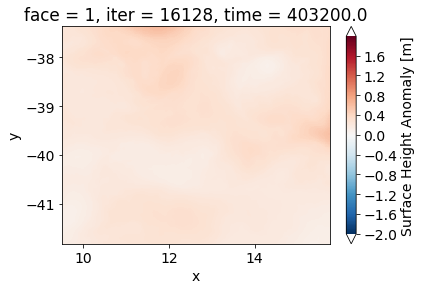

In [17]:
eta_merged.Eta.isel(time=0, i=slice(1200,1500), j=slice(1200,1500)).plot(x='x',y='y',levels=np.arange(-2,2,0.01),cbar_kwargs={'extend':'both'})

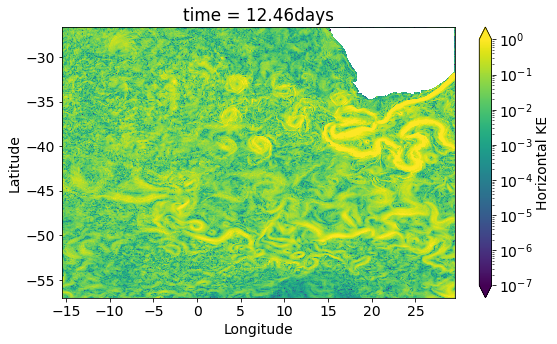

In [7]:
#ffmpeg -r 60 -f image2 -i fig%03d.jpg -vcodec libx264 -crf 25 -pix_fmt yuv420p vel.mp4
plt.figure(figsize=(8,5))
from matplotlib.colors import LogNorm
for tt in range(0,300):
    plt.clf()
    (uvel_merged.U**2+vvel_merged.V**2).where((uvel_merged.U**2+vvel_merged.V**2)>0).isel(time=tt).rename('Horizontal KE').plot.pcolormesh(
        x='x',y='y',norm=LogNorm(),vmin=10**-7,vmax=1,rasterized=True,cbar_kwargs={'extend':'both'})
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('time = ' + '{0:.2f}'.format((eta_merged.time.values[tt]-eta_merged.time.values[0])/3600/24)+ 'days')
    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig("/home/spencerj/agulhas-offline/movie/vel/fig{:03d}.jpg".format(tt))

In [4]:
ds = uvel_merged.merge(vvel_merged)

In [62]:
(eta_merged.y.isel(i=slice(1230,1300), j=slice(1230,1300)).min()).values

array(-41.378414, dtype=float32)

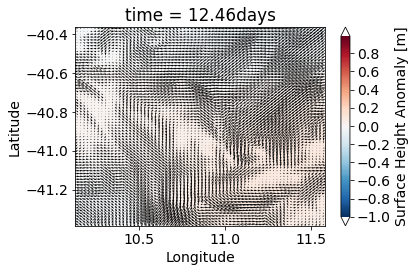

In [53]:
for tt in range(0,300):
    plt.clf()
    eta_merged.Eta.isel(time=tt, i=slice(1230,1300), j=slice(1230,1300)).plot(x='x',y='y',levels=np.arange(-1,1,0.01),cbar_kwargs={'extend':'both'})
    ds.isel(time=tt, i=slice(1230,1300), j=slice(1230,1300)).plot.quiver(x="x", y="y", u="U", v="V",scale=6,scale_units='xy',add_guide=False)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('time = ' + '{0:.2f}'.format((eta_merged.time.values[tt]-eta_merged.time.values[0])/3600/24)+ 'days')
    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig("/home/spencerj/agulhas-offline/movie/fig{:03d}.png".format(tt))

In [8]:
ds = xr.open_zarr('/swot/SUM01/spencer/36hr_timeseries/rechunked_6048.zarr')

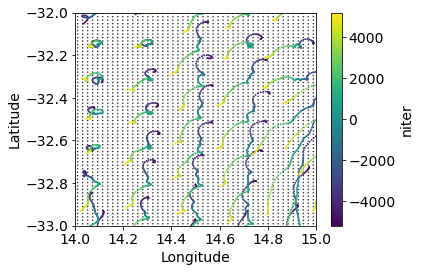

In [18]:
#eta_merged.Eta.where(eta_merged.Eta!=0).isel(time=0).plot.pcolormesh(x='x',y='y',levels=np.arange(-2,2,0.01),rasterized=True,cmap='Greys',add_colorbar=False)
ds.isel(z0=3,y0=slice(500,2000),x0=slice(1000,2000)).plot.scatter(x='x0', y='y0',hue='z0',cmap='binary', s=0.2,vmax=-0.4,vmin=-10,add_guide=False)
ds.isel(x0=np.arange(0,2160,10),y0=np.arange(0,2160,10),z0=3).plot.scatter(x='x', y='y', hue='niter',cmap='viridis', s=0.8)
plt.xlim(14,15)
plt.ylim(-33,-32)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("/home/spencerj/agulhas-offline/python/particle_traj.png")

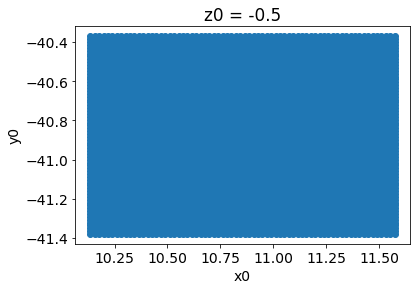

In [9]:
ds.isel(z0=3,y0=slice(1230,1300),x0=slice(1230,1300)).plot.scatter(x='x0', y='y0')

In [7]:
ds.isel(z0=3,y0=slice(1230,1300),x0=slice(1230,1300))

ValueError: Dimensions {'x0', 'y0', 'z0'} do not exist. Expected one or more of Frozen(SortedKeysDict({'i': 2160, 'time': 337, 'j': 2160}))